In [50]:
!pip install opencv-python

## 테스트 데이터셋 로드

In [51]:
import os
import urllib.request
import tarfile
import pickle
import numpy as np
from common.ResNet20 import ResNet20

def download_cifar100(save_path='cifar-100-python'):
    if os.path.exists(save_path):
        print("CIFAR-100 이미 존재")
        return

    url = 'https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz'
    filename = 'cifar-100-python.tar.gz'
    print("CIFAR-100 다운로드 중...")
    urllib.request.urlretrieve(url, filename)

    with tarfile.open(filename, 'r:gz') as tar:
        tar.extractall()
    os.remove(filename)
    print("다운로드 완료")

def load_batch(filepath):
    with open(filepath, 'rb') as f:
        data_dict = pickle.load(f, encoding='bytes')
    data = data_dict[b'data']
    fine_labels = np.array(data_dict[b'fine_labels'])
    coarse_labels = np.array(data_dict[b'coarse_labels'])
    data = data.reshape(-1, 3, 32, 32).astype(np.float32) / 255.0
    return data, fine_labels, coarse_labels

In [52]:
def load_cifar100_full(data_dir='./cifar-100-python', valid_ratio=0.1):
    # 1. Load train and test batch
    x_train_all, y_train_fine_all, y_train_coarse_all = load_batch(os.path.join(data_dir, 'train'))
    x_test, y_test_fine, y_test_coarse = load_batch(os.path.join(data_dir, 'test'))

    # 2. Split train → train + validation
    num_total = x_train_all.shape[0]
    num_valid = int(num_total * valid_ratio)

    x_valid = x_train_all[:num_valid]
    t_valid_fine = y_train_fine_all[:num_valid]
    t_valid_coarse = y_train_coarse_all[:num_valid]

    x_train = x_train_all[num_valid:]
    t_train_fine = y_train_fine_all[num_valid:]
    t_train_coarse = y_train_coarse_all[num_valid:]

    # 3. Return all
    return (x_train, x_valid, x_test,
            t_train_coarse, t_valid_coarse, y_test_coarse,
            t_train_fine, t_valid_fine, y_test_fine)

In [53]:
# CIFAR-100 다운로드
download_cifar100()

# 전체 데이터셋 로드
(x_train, x_valid, x_test,
 t_train_coarse, t_valid_coarse, t_test_coarse,
 t_train_fine, t_valid_fine, t_test_fine) = load_cifar100_full()

# 확인 출력
print("CIFAR-100 데이터셋 로드 완료:")
print(" - x_train:", x_train.shape)
print(" - x_valid:", x_valid.shape)
print(" - x_test :", x_test.shape)
print(" - t_train_fine :", t_train_fine.shape)
print(" - t_valid_fine :", t_valid_fine.shape)
print(" - t_test_fine  :", t_test_fine.shape)
print(" - t_train_coarse:", t_train_coarse.shape)
print(" - t_valid_coarse:", t_valid_coarse.shape)
print(" - t_test_coarse :", t_test_coarse.shape)


CIFAR-100 이미 존재
CIFAR-100 데이터셋 로드 완료:
 - x_train: (45000, 3, 32, 32)
 - x_valid: (5000, 3, 32, 32)
 - x_test : (10000, 3, 32, 32)
 - t_train_fine : (45000,)
 - t_valid_fine : (5000,)
 - t_test_fine  : (10000,)
 - t_train_coarse: (45000,)
 - t_valid_coarse: (5000,)
 - t_test_coarse : (10000,)


In [54]:
def restore_model_parameters(model, model_state):
    
    model.conv1.W = model_state['conv1_W']
    model.conv1.b = model_state['conv1_b']

    model.fc.W = model_state['fc_W']
    model.fc.b = model_state['fc_b']

    idx = 0
    for block in model.layer1 + model.layer2 + model.layer3:
        for attr in ['conv1', 'conv2', 'shortcut']:
            if hasattr(block, attr):
                conv = getattr(block, attr)
                conv.W = model_state[f'{idx}_W']
                conv.b = model_state[f'{idx}_b']
                idx += 1

def restore_bn_params(model, state):
    bn_count = 0
    for block in model.layer1 + model.layer2 + model.layer3:
        for attr in ['bn1', 'bn2']:
            bn = getattr(block, attr)
            bn.gamma = state[f'{bn_count}_gamma']
            bn.beta = state[f'{bn_count}_beta']
            bn.running_mean = state[f'{bn_count}_running_mean']
            bn.running_var = state[f'{bn_count}_running_var']
            bn_count += 1
        if hasattr(block, 'bn_shortcut'):
            bn = block.bn_shortcut
            bn.gamma = state[f'{bn_count}_gamma']
            bn.beta = state[f'{bn_count}_beta']
            bn.running_mean = state[f'{bn_count}_running_mean']
            bn.running_var = state[f'{bn_count}_running_var']
            bn_count += 1

    bn = model.bn1
    bn.gamma = state[f'{bn_count}_gamma']
    bn.beta = state[f'{bn_count}_beta']
    bn.running_mean = state[f'{bn_count}_running_mean']
    bn.running_var = state[f'{bn_count}_running_var']

In [55]:
from common.ResNet20 import ResNet20

model = ResNet20()

with open("ResNet-20_ex3_epoch35.pkl", "rb") as f:
    checkpoint = pickle.load(f)
    model_state = checkpoint["model"]
    
restore_bn_params(model, model_state)
restore_model_parameters(model, model_state)

In [56]:
print("fc_W std:", np.std(model.fc.W))
print("fc_b std:", np.std(model.fc.b))
print("conv1_W std:", np.std(model.conv1.W))

fc_W std: 0.6664150180785455
fc_b std: 0.5734404252260701
conv1_W std: 0.6502085230788551


In [57]:
from common.functions import softmax  

def evaluate_model(model, x, y_true):
    batch_size = 100
    preds = []
    for i in range(0, x.shape[0], batch_size):
        x_batch = x[i:i+batch_size]
        logits = model.predict(x_batch)        
        probs = softmax(logits)                
        y_pred = np.argmax(probs, axis=1)
        preds.append(y_pred)
    preds = np.concatenate(preds)
    acc = np.sum(preds == y_true) / len(y_true)
    return preds, acc


In [15]:
fine_preds, fine_acc = evaluate_model(model, x_train, t_train_fine)
print(f"[🎯 Fine Label] Train Accuracy: {fine_acc:.4f}")

[🎯 Fine Label] Train Accuracy: 0.6646


In [16]:
fine_valid_preds, fine_valid_acc = evaluate_model(model, x_valid, t_valid_fine)
print(f"[🎯 Fine Label] Valid Accuracy: {fine_valid_acc:.4f}")

[🎯 Fine Label] Valid Accuracy: 0.6566


In [17]:
fine_test_preds, fine_test_acc = evaluate_model(model, x_test, t_test_fine)
print(f"[🎯 Fine Label] Test Accuracy: {fine_test_acc:.4f}")

[🎯 Fine Label] Test Accuracy: 0.5381


## 시각화 함수

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from common.ResNet20 import ResNet20  # 사용자 정의 모델
import cv2

# --- 2. t-SNE 시각화 ---
def extract_features(model, x_data, batch_size=100):
    features = []
    labels = []
    for i in range(0, len(x_data[0]), batch_size):
        x_batch = x_data[0][i:i+batch_size]
        t_batch = x_data[1][i:i+batch_size]
        _ = model.forward(x_batch, train_flg=False)
        pooled = model.pooled.copy()
        features.append(pooled)
        labels.append(t_batch)
    return np.concatenate(features, axis=0), np.concatenate(labels, axis=0)

def visualize_tsne(model, x_data, title="t-SNE"):
    features, labels = extract_features(model, x_data)
    tsne = TSNE(n_components=2, random_state=42, init='pca')
    reduced = tsne.fit_transform(features)
    plt.figure(figsize=(10, 10))
    for i in range(100):
        idx = labels == i
        plt.scatter(reduced[idx, 0], reduced[idx, 1], label=str(i), alpha=0.6, s=20)
    plt.axis('equal')
    plt.title(title)
    plt.legend(markerscale=2, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=6, ncol=2)
    plt.tight_layout()
    plt.show()


def visualize_tsne_coarse(model, x_data, title="t-SNE (Coarse Label)"):
    from common.coarse_mapping import get_cifar100_fine_to_coarse_dict

    # 1. unpack
    x_input, fine_labels = x_data

    # 2. feature 추출
    features = []
    for i in range(0, len(x_input), 100):
        x_batch = x_input[i:i+100]
        _ = model.forward(x_batch, train_flg=False)
        features.append(model.pooled.copy())
    features = np.concatenate(features, axis=0)

    # 3. fine → coarse 매핑
    f2c = get_cifar100_fine_to_coarse_dict()
    coarse_labels = np.array([f2c[f] for f in fine_labels])

    # 4. t-SNE 수행
    tsne = TSNE(n_components=2, random_state=42, init='pca')
    reduced = tsne.fit_transform(features)

    # 5. 시각화
    plt.figure(figsize=(10, 10))
    for i in range(20):
        idx = coarse_labels == i
        plt.scatter(reduced[idx, 0], reduced[idx, 1], label=f"coarse {i}", alpha=0.6, s=20)
    plt.axis('equal')
    plt.title(title)
    plt.legend(markerscale=2, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    plt.tight_layout()
    plt.show()


import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from common.coarse_mapping import get_cifar100_fine_to_coarse_dict
from common.functions import softmax


def plot_confusion_matrix_sns(y_true, y_pred, num_classes, title, class_labels=None, normalize=False):
    from sklearn.metrics import confusion_matrix
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns

    cm = confusion_matrix(y_true, y_pred, labels=np.arange(num_classes),
                          normalize='true' if normalize else None)

    annot = np.full_like(cm, "", dtype=object)
    for i in range(min(cm.shape[0], cm.shape[1])):
        val = cm[i, i]
        annot[i, i] = f"{val:.2f}" if normalize else f"{int(val)}"

    plt.figure(figsize=(6, 5))
    ax = sns.heatmap(cm,
                     annot=annot,
                     fmt="",  # 이미 문자열이므로 포맷 불필요
                     cmap='Blues',
                     annot_kws={'color': 'black'}) 
    

    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")
    ax.set_title(title)

    tick_freq = 5
    ticks = np.arange(0, num_classes, tick_freq)
    tick_labels = [str(i) for i in ticks]  # 숫자 문자열로 변환

    ax.set_xticks(ticks)
    ax.set_xticklabels(tick_labels, rotation=90, fontsize=6)
    ax.set_yticks(ticks)
    ax.set_yticklabels(tick_labels, fontsize=6)

    plt.tight_layout()
    plt.show()

    

## train set mapping

In [ ]:
## train set
import numpy as np
from common.functions import softmax
from common.coarse_mapping import get_cifar100_fine_to_coarse_dict, CoarseMapper, compute_coarse_accuracy, compute_fine_class_accuracy

# 1. fine → coarse 매핑 딕셔너리 및 매퍼 클래스 준비
f2c = get_cifar100_fine_to_coarse_dict()
mapper = CoarseMapper(f2c)

# 2. 모델 출력 얻기
logits = model.predict(x_train)          # (N, 100)
fine_probs = softmax(logits)             # (N, 100)
fine_preds = np.argmax(fine_probs, axis=1)

# 3. 정답 coarse label 변환
true_coarse = np.array([f2c[f] for f in t_train_fine])

# 4. 각 방식별 coarse 예측 및 정확도 계산
# 방식 1: Argmax 기반
pred_coarse_1 = mapper.argmax_mapping(fine_probs)
acc1 = compute_coarse_accuracy(pred_coarse_1, true_coarse)
print(f"[🎯 방식 1 - Argmax Mapping]     Coarse Accuracy: {acc1:.4f}")

# 방식 2: Entropy Weighted Mapping
pred_coarse_2 = mapper.entropy_weighted_mapping(fine_probs)
acc2 = compute_coarse_accuracy(pred_coarse_2, true_coarse)
print(f"[🔍 방식 2 - Entropy Weighted]   Coarse Accuracy: {acc2:.4f}")

# 방식 3: Soft Average Mapping
pred_coarse_3 = mapper.soft_average_mapping(fine_probs)
acc3 = compute_coarse_accuracy(pred_coarse_3, true_coarse)
print(f"[🧪 방식 3 - Soft Average]        Coarse Accuracy: {acc3:.4f}")

# 방식 4: Validation Guided Mapping
# fine class별 accuracy 기반 가중치 구하기
fine_weights = compute_fine_class_accuracy(fine_preds, t_train_fine)
pred_coarse_4 = mapper.validation_guided_mapping(fine_probs, fine_weights)
acc4 = compute_coarse_accuracy(pred_coarse_4, true_coarse)
print(f"[📊 방식 4 - Validation Guided]  Coarse Accuracy: {acc4:.4f}")



## valid set mapping

In [22]:
## valid set
import numpy as np
from common.functions import softmax
from common.coarse_mapping import (
    get_cifar100_fine_to_coarse_dict,
    CoarseMapper,
    compute_fine_class_accuracy,
    compute_coarse_accuracy
)

# 1. 딕셔너리 및 coarse 매퍼 초기화
f2c = get_cifar100_fine_to_coarse_dict()
mapper = CoarseMapper(f2c)

# 2. validation set 예측
val_logits = model.predict(x_valid)            # (N, 100)
val_probs = softmax(val_logits)
val_preds = np.argmax(val_probs, axis=1)
true_coarse_val = np.array([f2c[f] for f in t_valid_fine])  # 정답 coarse

# 3. fine accuracy 계산 (자체 validation용 가중치 생성)
fine_weights_val = compute_fine_class_accuracy(val_preds, t_valid_fine)  # (100,)

# 4. coarse mapping 방식별 평가

# [1] Argmax Mapping
pred_coarse_1 = mapper.argmax_mapping(val_probs)
acc1 = compute_coarse_accuracy(pred_coarse_1, true_coarse_val)
print(f"[Argmax Mapping]     Validation Coarse Accuracy: {acc1:.4f}")

# [2] Entropy Weighted Mapping
pred_coarse_2 = mapper.entropy_weighted_mapping(val_probs)
acc2 = compute_coarse_accuracy(pred_coarse_2, true_coarse_val)
print(f"[Entropy Weighted]   Validation Coarse Accuracy: {acc2:.4f}")

# [3] Soft Average Mapping
pred_coarse_3 = mapper.soft_average_mapping(val_probs)
acc3 = compute_coarse_accuracy(pred_coarse_3, true_coarse_val)
print(f"[Soft Average]        Validation Coarse Accuracy: {acc3:.4f}")

# [4] Validation Guided Mapping (val 내부에서 weight 추정)
pred_coarse_4 = mapper.validation_guided_mapping(val_probs, fine_weights_val)
acc4 = compute_coarse_accuracy(pred_coarse_4, true_coarse_val)
print(f"[Validation Guided]  Validation Coarse Accuracy: {acc4:.4f}")


[Argmax Mapping]     Validation Coarse Accuracy: 0.7584
[Entropy Weighted]   Validation Coarse Accuracy: 0.7660
[Soft Average]        Validation Coarse Accuracy: 0.7660
[Validation Guided]  Validation Coarse Accuracy: 0.7488


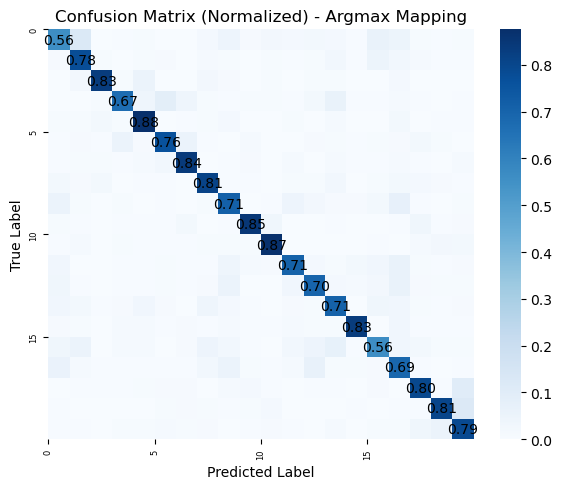

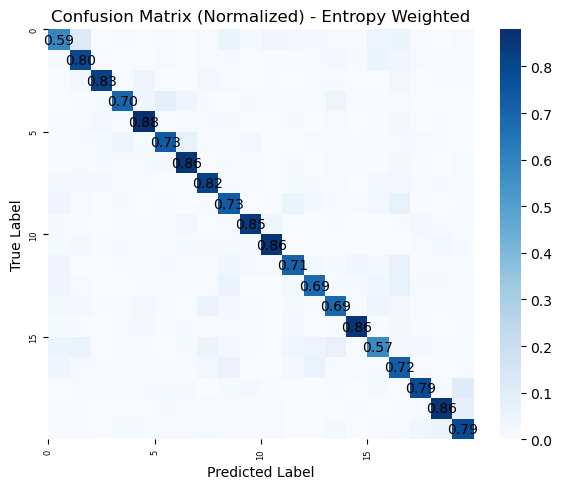

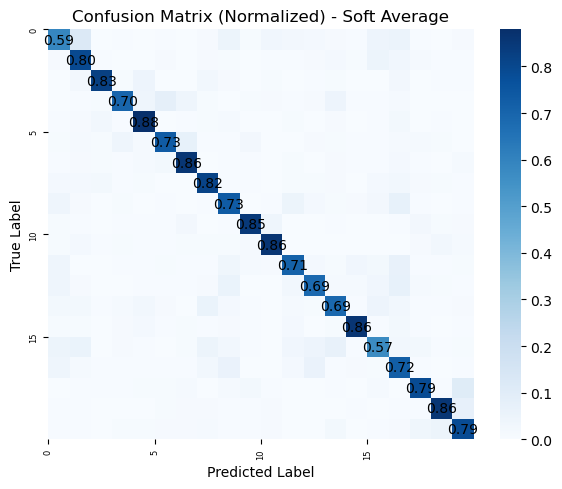

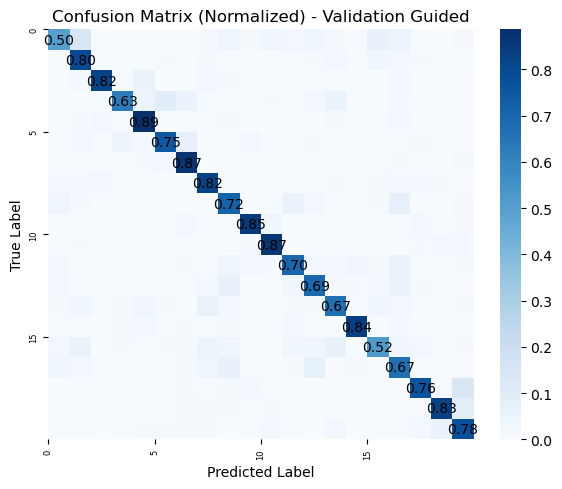

In [59]:
plot_confusion_matrix_sns(true_coarse_val, pred_coarse_1, 20, "Confusion Matrix (Normalized) - Argmax Mapping", normalize=True)
plot_confusion_matrix_sns(true_coarse_val, pred_coarse_2, 20, "Confusion Matrix (Normalized) - Entropy Weighted", normalize=True)
plot_confusion_matrix_sns(true_coarse_val, pred_coarse_3, 20, "Confusion Matrix (Normalized) - Soft Average", normalize=True)
plot_confusion_matrix_sns(true_coarse_val, pred_coarse_4, 20, "Confusion Matrix (Normalized) - Validation Guided", normalize=True)

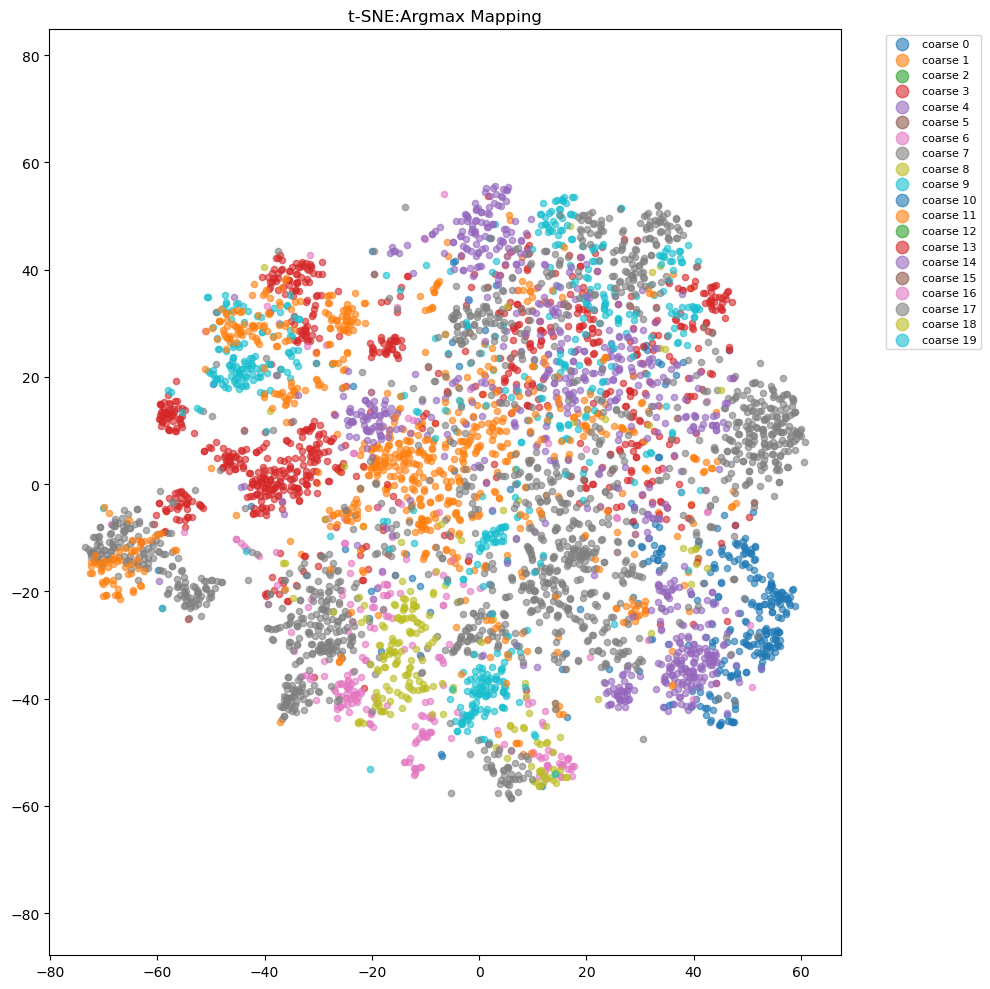

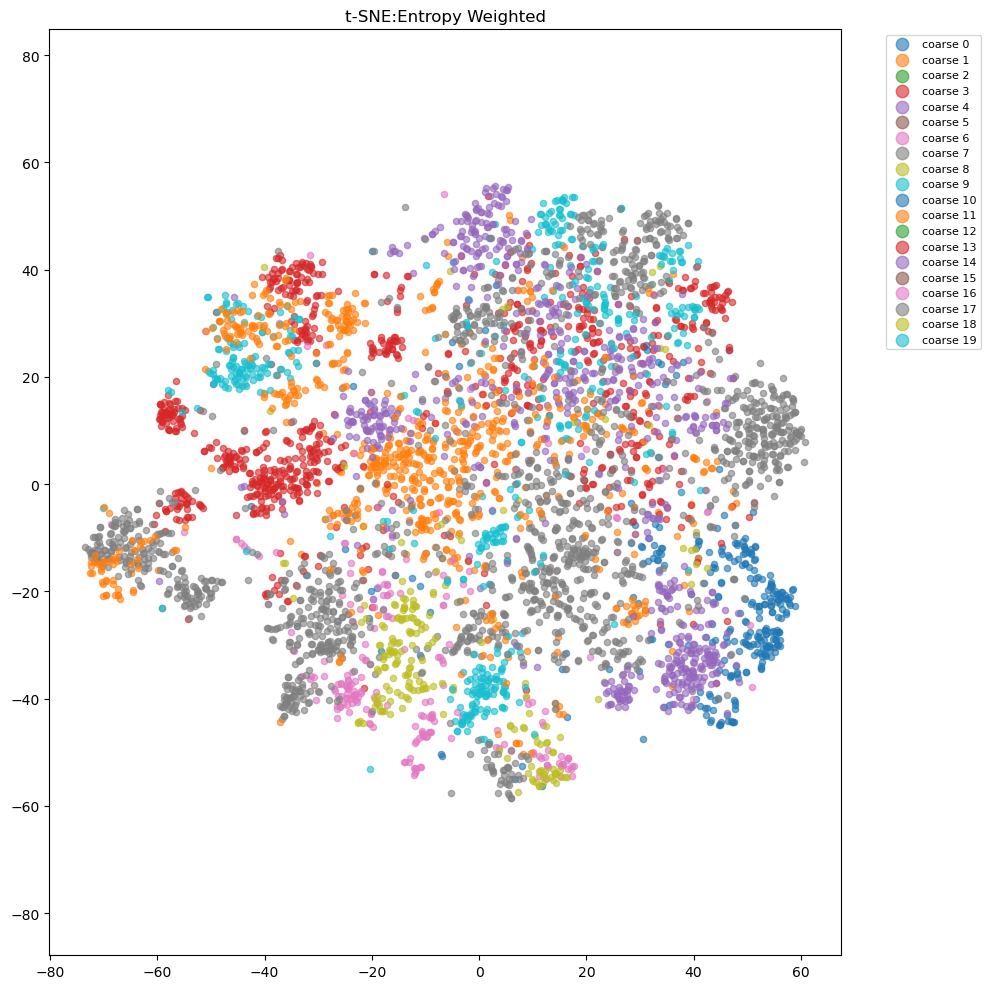

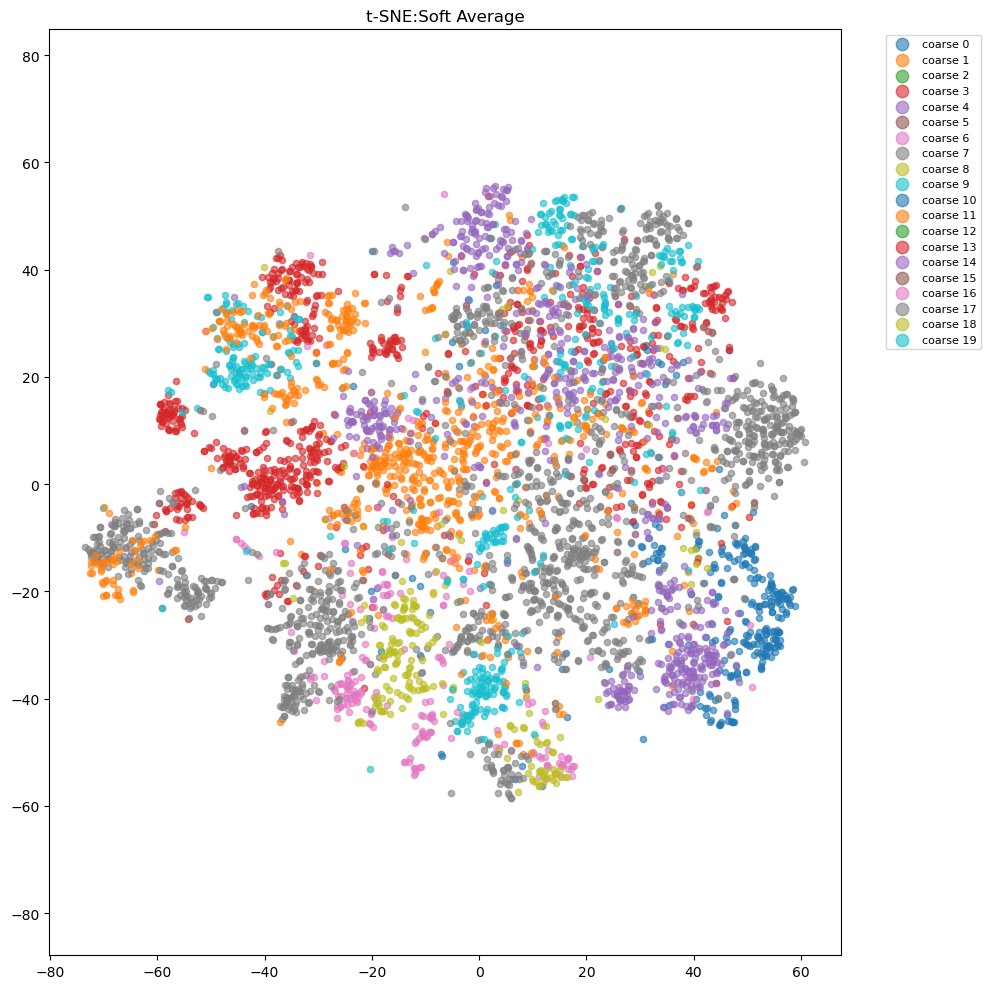

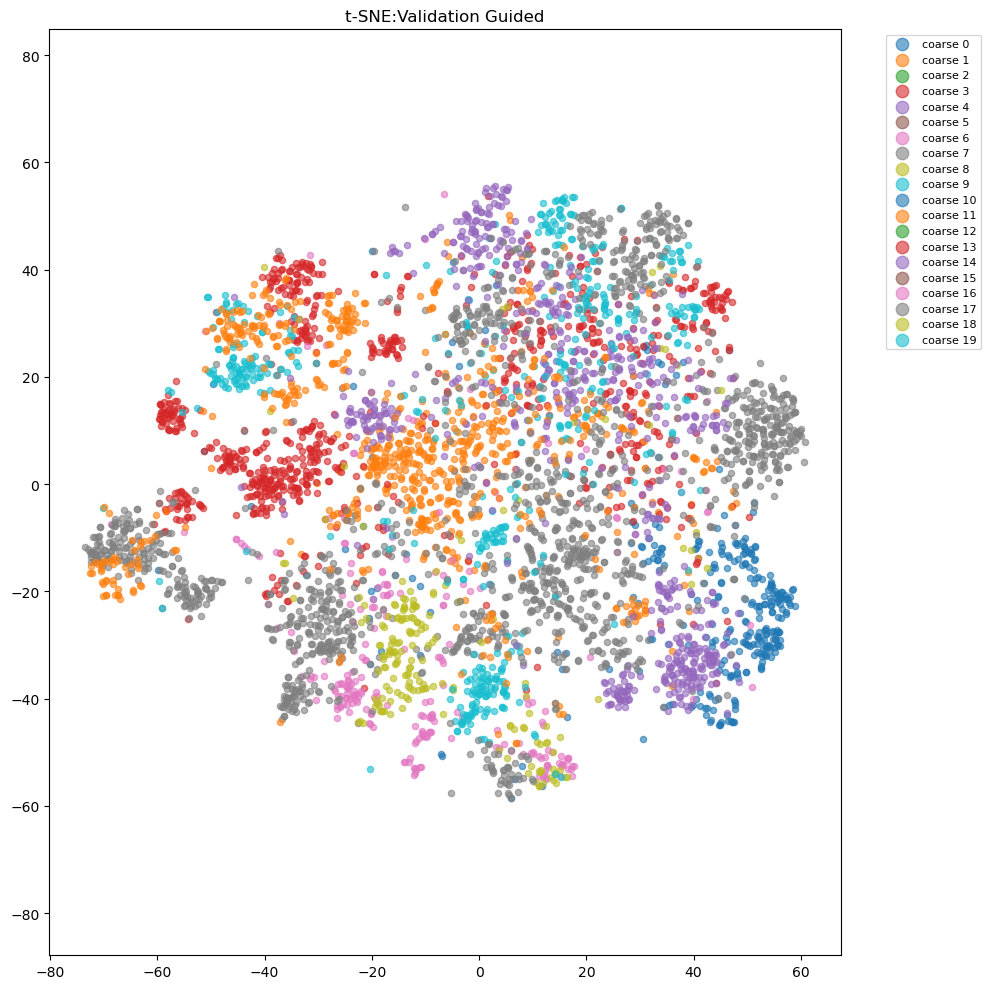

In [60]:
visualize_tsne_coarse(model, (x_valid, pred_coarse_1),   title="t-SNE:Argmax Mapping")
visualize_tsne_coarse(model, (x_valid, pred_coarse_2),  title="t-SNE:Entropy Weighted")
visualize_tsne_coarse(model, (x_valid, pred_coarse_3),  title="t-SNE:Soft Average")
visualize_tsne_coarse(model, (x_valid, pred_coarse_4), title="t-SNE:Validation Guided")

## test set mapping

In [61]:
## test set
import numpy as np
from common.functions import softmax
from common.coarse_mapping import (
    get_cifar100_fine_to_coarse_dict,
    CoarseMapper,
    compute_fine_class_accuracy,
    compute_coarse_accuracy
)

# 1. 매핑 딕셔너리 및 매퍼 준비
f2c = get_cifar100_fine_to_coarse_dict()
mapper = CoarseMapper(f2c)

# 2. validation set으로 fine accuracy → weight 계산
val_logits = model.predict(x_valid)              # (num_val, 100)
val_probs = softmax(val_logits)
val_preds = np.argmax(val_probs, axis=1)
fine_weights = compute_fine_class_accuracy(val_preds, t_valid_fine)  # (100,)

# 3. test set 예측
test_logits = model.predict(x_test)              # (num_test, 100)
test_probs = softmax(test_logits)
test_fine_preds = np.argmax(test_probs, axis=1)
true_coarse = np.array([f2c[f] for f in t_test_fine])  # 정답 coarse

# 4. coarse mapping 방식별 평가
# [1] Argmax Mapping
pred_coarse_1 = mapper.argmax_mapping(test_probs)
acc1 = compute_coarse_accuracy(pred_coarse_1, true_coarse)
print(f"[🎯 방식 1 - Argmax Mapping]     Test Coarse Accuracy: {acc1:.4f}")

# [2] Entropy Weighted Mapping
pred_coarse_2 = mapper.entropy_weighted_mapping(test_probs)
acc2 = compute_coarse_accuracy(pred_coarse_2, true_coarse)
print(f"[🔍 방식 2 - Entropy Weighted]   Test Coarse Accuracy: {acc2:.4f}")

# [3] Soft Average Mapping
pred_coarse_3 = mapper.soft_average_mapping(test_probs)
acc3 = compute_coarse_accuracy(pred_coarse_3, true_coarse)
print(f"[🧪 방식 3 - Soft Average]        Test Coarse Accuracy: {acc3:.4f}")

# [4] Validation Guided Mapping (with val weights)
pred_coarse_4 = mapper.validation_guided_mapping(test_probs, fine_weights)
acc4 = compute_coarse_accuracy(pred_coarse_4, true_coarse)
print(f"[📊 방식 4 - Validation Guided]  Test Coarse Accuracy: {acc4:.4f}")


[🎯 방식 1 - Argmax Mapping]     Test Coarse Accuracy: 0.6557
[🔍 방식 2 - Entropy Weighted]   Test Coarse Accuracy: 0.6671
[🧪 방식 3 - Soft Average]        Test Coarse Accuracy: 0.6671
[📊 방식 4 - Validation Guided]  Test Coarse Accuracy: 0.6573


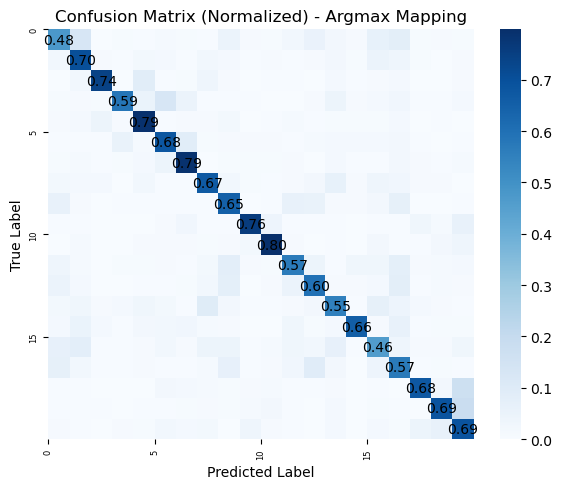

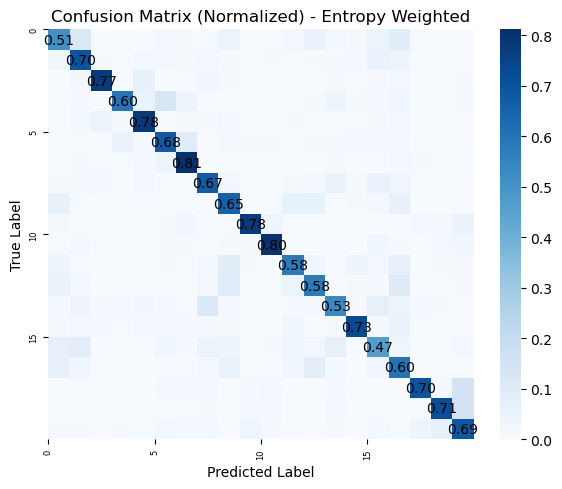

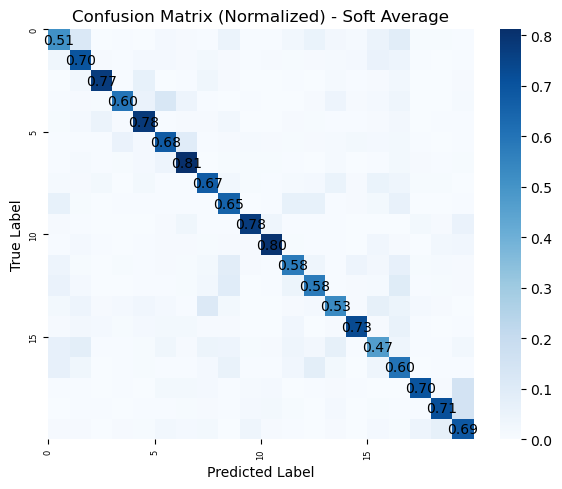

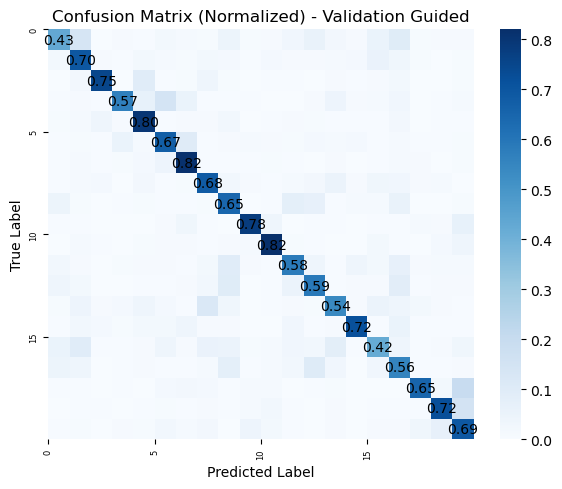

In [62]:
plot_confusion_matrix_sns(true_coarse, pred_coarse_1, 20, "Confusion Matrix (Normalized) - Argmax Mapping", normalize=True)
plot_confusion_matrix_sns(true_coarse, pred_coarse_2, 20, "Confusion Matrix (Normalized) - Entropy Weighted", normalize=True)
plot_confusion_matrix_sns(true_coarse, pred_coarse_3, 20, "Confusion Matrix (Normalized) - Soft Average", normalize=True)
plot_confusion_matrix_sns(true_coarse, pred_coarse_4, 20, "Confusion Matrix (Normalized) - Validation Guided", normalize=True)

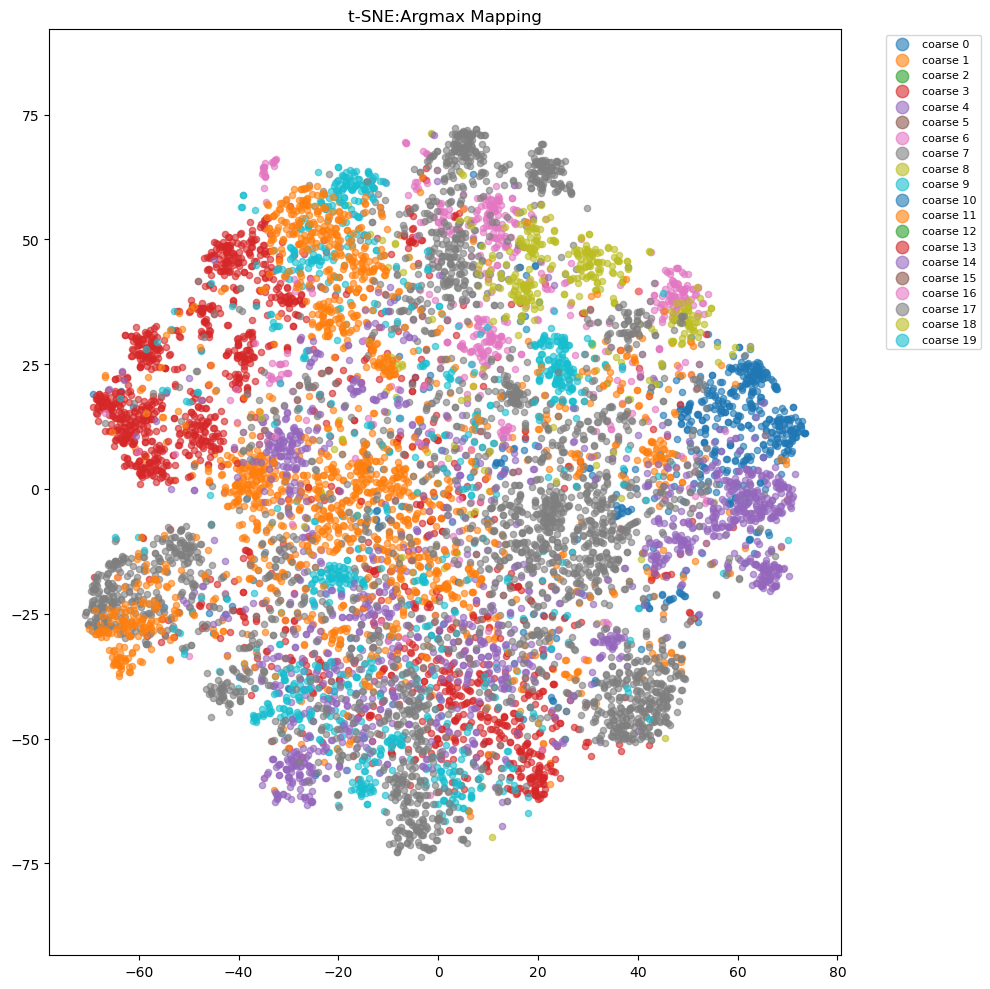

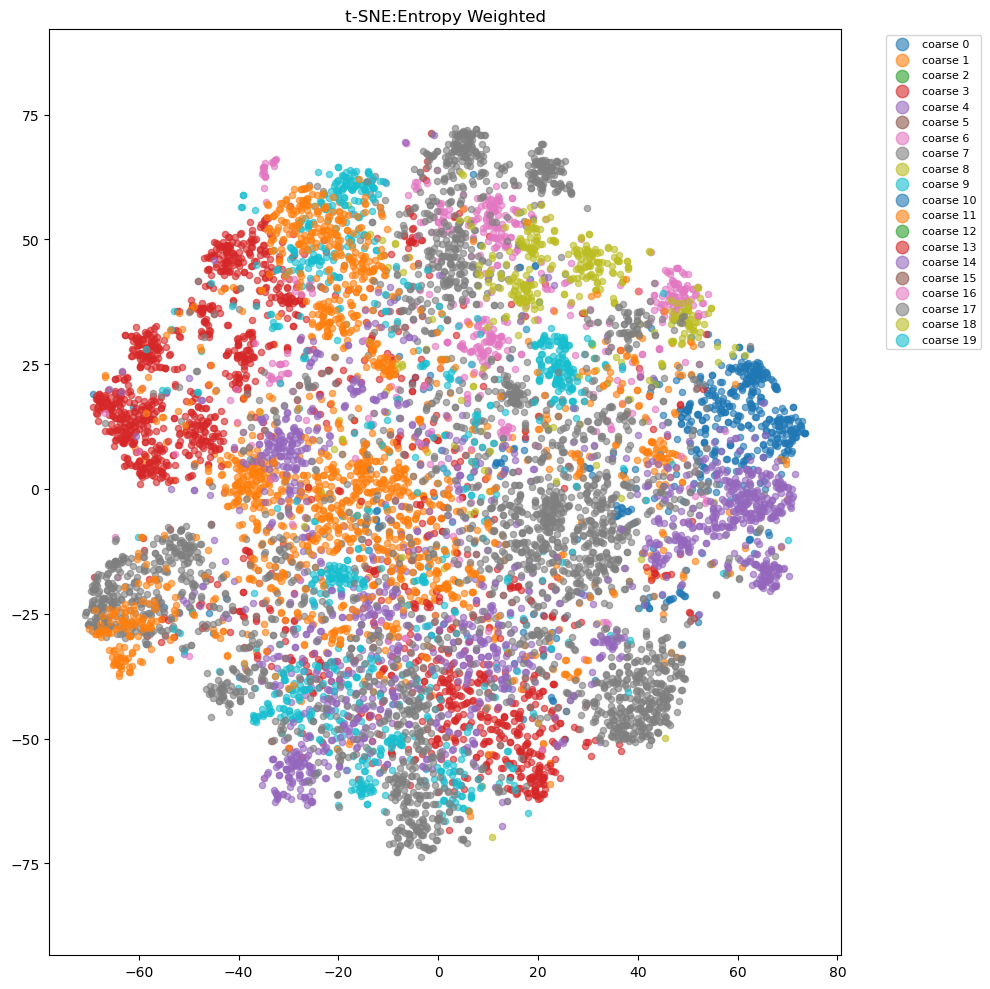

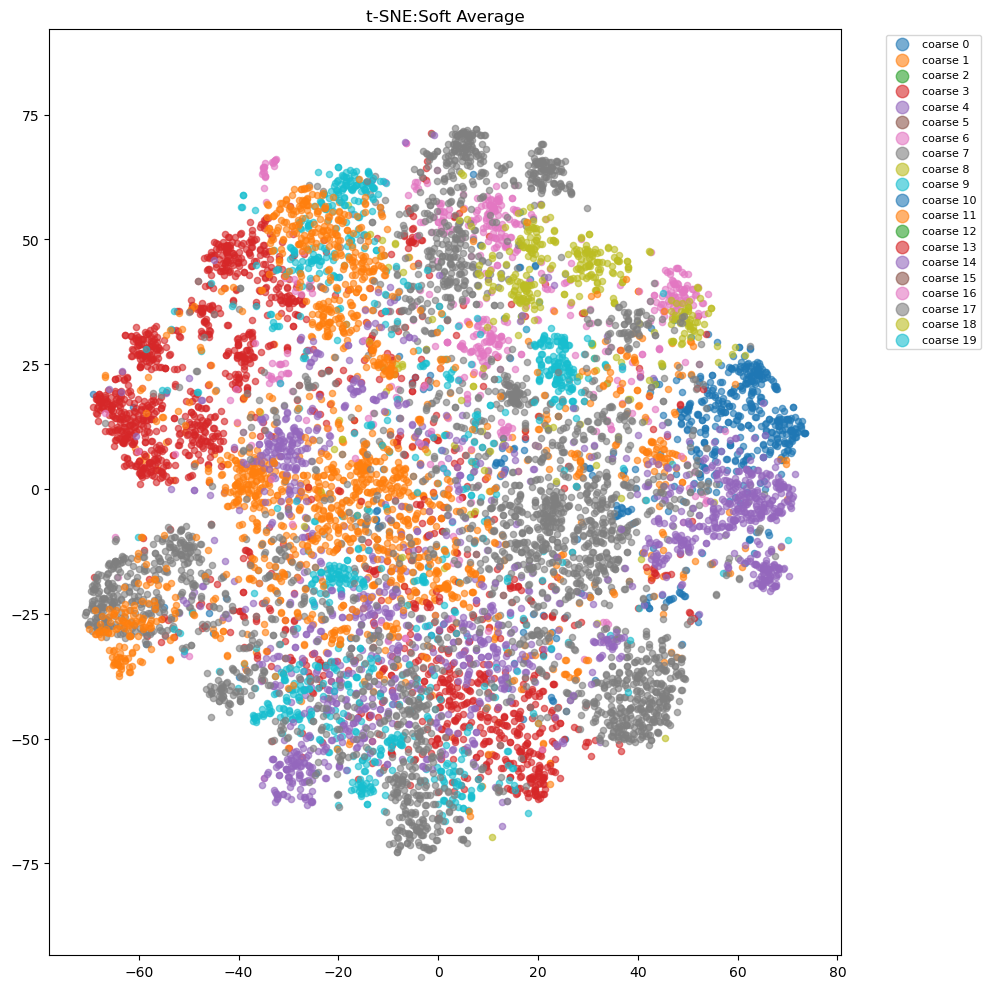

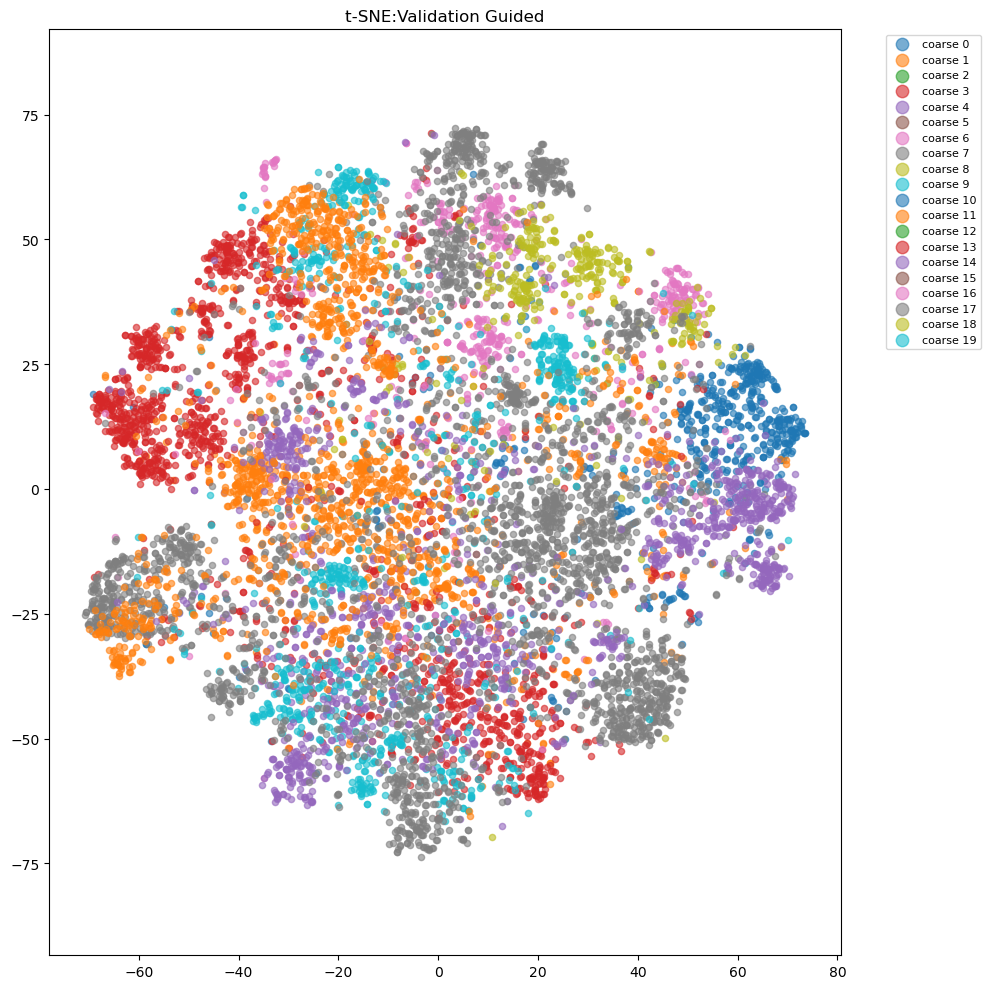

In [63]:
visualize_tsne_coarse(model, (x_test, pred_coarse_1),   title="t-SNE:Argmax Mapping")
visualize_tsne_coarse(model, (x_test, pred_coarse_2),  title="t-SNE:Entropy Weighted")
visualize_tsne_coarse(model, (x_test, pred_coarse_3),  title="t-SNE:Soft Average")
visualize_tsne_coarse(model, (x_test, pred_coarse_4), title="t-SNE:Validation Guided")